# Blackbody fit

- Require 01_01_sn2009ip_clean.dat
- Require blackbody.py, mag_flux_convert.py
- No extinction correction
- Blackbody fits include all-band ($UVW2$--$KS$), UV ($UVW2$--$UVW1$), optical ($VRI$), NIR ($H/KS$)
- Apply linear interpolation, without extrapolation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as intpol
from scipy.optimize import curve_fit
import numpy as np
from blackbody import *
from mag_flux_convert import *
from vega2ab import *

wavelength = {'UVW2':1928., 'UVM2':2246., 'UVW1':2600., 'U':3465., 'B':4392., 'V':5468., 'R':6442., 'I':7994., 
       'J':12200., 'H':16458., 'KS':21603.}
col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}

In [2]:
def get_mag_interpol(mag_intpol, day):
    """return x = numpy.array of wavelength, y = numpy.array of intpolated magnitude, z = numpy.array of band
    mag_intpol = dict of scipy.interpolate.interp1d with keys as bands
    day = one number representing day for interpolation
    wavelength = dict of wavelength with keys as bands, pre-defined"""
    x = []
    y = []
    z = []
    for i in mag_intpol.keys():
        if np.isnan(mag_intpol[i](day).tolist()):
            continue
        x.append(wavelength[i])
        y.append(mag_intpol[i](day).tolist())
        z.append(i)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x, y, z

In [3]:
# load
sn = pd.read_csv(r"D:\Unknown 3rd project\2009ip\Default\python\01_01_sn2009ip_clean.dat")

In [4]:
# explore
sn.columns
sn['band'].unique()

array(['UVW1', 'U', 'UVW2', 'UVM2', 'B', 'I', 'R', 'V', 'H', 'J', 'KS'],
      dtype=object)

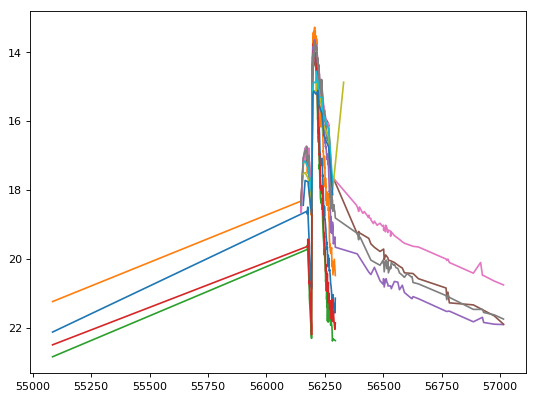

In [5]:
# plot
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
for i in sn['band'].unique():
    x = sn[['MJD', 'ABmag']].where(sn['band'] == i).dropna()
    plt.plot(x['MJD'], x['ABmag'])
plt.gca().invert_yaxis()
plt.show()

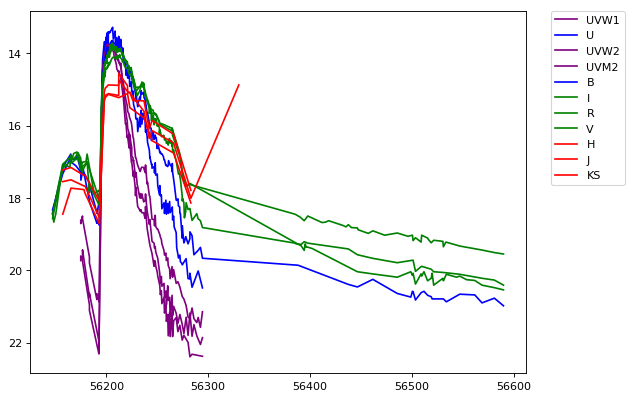

In [6]:
# plot
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
for i in sn['band'].unique():
    x = sn[['MJD', 'ABmag']].where(sn['band'] == i).dropna().query('MJD>56000 & MJD<56600')
    plt.plot(x['MJD'], x['ABmag'], color=col[i], label=i)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
# subset 56000--56600
dat = sn.query('MJD>=56000 & MJD<=56600')
dat.head()

,MJD,ABmag,emag,band
4,56147.23,18.42,0.01,B
5,56147.23,18.57,0.05,I
6,56147.23,18.43,0.03,R
7,56147.23,18.33,0.01,U
8,56147.23,18.45,0.04,V


In [8]:
# interpolate for each band
mag_intpol = {}
for i in dat['band'].unique():
    mag_intpol[i] = intpol.interp1d(
        dat['MJD'].where(dat['band'] == i).dropna(), 
        dat['ABmag'].where(dat['band'] == i).dropna(), 
        fill_value=None, bounds_error=False)

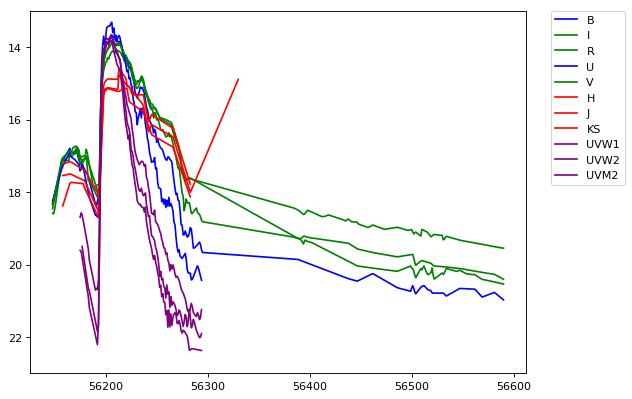

In [62]:
# plot interpolate
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
z = np.arange(56000, 56600, step=1)
col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}
for i in mag_intpol.keys():
    plt.plot(z, mag_intpol[i](z), color=col[i], label=i)
plt.ylim(13, 23)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [10]:
# fit blackbody
# UV--KS
z = np.arange(56000, 56600, step=1)
MJD = []
param = []
paramcov = []
for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
    if y.size < 3:
        continue
    popt, pcov = curve_fit(bb_lambda_mag, x, y, p0=[5000., -20.])
    MJD.append(j)
    param.append(popt)
    paramcov.append(pcov)
MJD = np.array(MJD)
param = np.array(param)
paramcov = np.array(paramcov)

In [103]:
# fit BB : UVW2--UVW1 + B--I + H--KS
z = np.arange(56000, 56600, step=1)
band_1 = set(['B','V','R','I'])
band_2 = set(['U','B','V','R','I'])
band_3 = set(['UVW2', 'UVM2', 'UVW1', 'U', 'B', 'V', 'R', 'I'])
band_4 = set(['B','V','I'])
band_5 = set(['U','I'])
band_6 = set(['UVW2','U'])
band_7 = set(['B','I'])

MJD_band_1, param_band_1, pcov_band_1 = [], [], []
MJD_band_2, param_band_2, pcov_band_2 = [], [], []
MJD_band_3, param_band_3, pcov_band_3 = [], [], []
MJD_band_4, param_band_4, pcov_band_4 = [], [], []
MJD_band_5, param_band_5, pcov_band_5 = [], [], []
MJD_band_6, param_band_6, pcov_band_6 = [], [], []
MJD_band_7, param_band_7, pcov_band_7 = [], [], []

for j in z:
    x, y, a = get_mag_interpol(mag_intpol, j)
    x_band_1, y_band_1 = [], []
    x_band_2, y_band_2 = [], []
    x_band_3, y_band_3 = [], []
    x_band_4, y_band_4 = [], []
    x_band_5, y_band_5 = [], []
    x_band_6, y_band_6 = [], []
    x_band_7, y_band_7 = [], []
    for i in a:
        if i in band_1:
            x_band_1.append(wavelength[i])
            y_band_1.append(y[np.where(a == i)].tolist()[0])
        if i in band_2:
            x_band_2.append(wavelength[i])
            y_band_2.append(y[np.where(a == i)].tolist()[0])
        if i in band_3:
            x_band_3.append(wavelength[i])
            y_band_3.append(y[np.where(a == i)].tolist()[0])
        if i in band_4:
            x_band_4.append(wavelength[i])
            y_band_4.append(y[np.where(a == i)].tolist()[0])
        if i in band_5:
            x_band_5.append(wavelength[i])
            y_band_5.append(y[np.where(a == i)].tolist()[0])
        if i in band_6:
            x_band_6.append(wavelength[i])
            y_band_6.append(y[np.where(a == i)].tolist()[0])
        if i in band_7:
            x_band_7.append(wavelength[i])
            y_band_7.append(y[np.where(a == i)].tolist()[0])
            
    x_band_1, y_band_1 = np.array(x_band_1), np.array(y_band_1)
    x_band_2, y_band_2 = np.array(x_band_2), np.array(y_band_2)
    x_band_3, y_band_3 = np.array(x_band_3), np.array(y_band_3)
    x_band_4, y_band_4 = np.array(x_band_4), np.array(y_band_4)
    x_band_5, y_band_5 = np.array(x_band_5), np.array(y_band_5)
    x_band_6, y_band_6 = np.array(x_band_6), np.array(y_band_6)
    x_band_7, y_band_7 = np.array(x_band_7), np.array(y_band_7)
    
    if x_band_1.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_1, y_band_1, p0=[5000., -20.])
        MJD_band_1.append(j)
        param_band_1.append(popt)
        pcov_band_1.append(pcov)
    if x_band_2.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_2, y_band_2, p0=[5000., -20.])
        MJD_band_2.append(j)
        param_band_2.append(popt)
        pcov_band_2.append(pcov)
    if x_band_3.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_3, y_band_3, p0=[5000., -20.])
        MJD_band_3.append(j)
        param_band_3.append(popt)
        pcov_band_3.append(pcov)
    if x_band_4.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_4, y_band_4, p0=[5000., -20.])
        MJD_band_4.append(j)
        param_band_4.append(popt)
        pcov_band_4.append(pcov)
    if x_band_5.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_5, y_band_5, p0=[5000., -20.])
        MJD_band_5.append(j)
        param_band_5.append(popt)
        pcov_band_5.append(pcov)
    if x_band_6.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_6, y_band_6, p0=[5000., -20.])
        MJD_band_6.append(j)
        param_band_6.append(popt)
        pcov_band_6.append(pcov)
    if x_band_7.size >= 2:
        popt, pcov = curve_fit(bb_lambda_mag, x_band_7, y_band_7, p0=[5000., -20.])
        MJD_band_7.append(j)
        param_band_7.append(popt)
        pcov_band_7.append(pcov)
        
MJD_band_1, param_band_1, pcov_band_1 = np.array(MJD_band_1), np.array(param_band_1), np.array(pcov_band_1)
MJD_band_2, param_band_2, pcov_band_2 = np.array(MJD_band_2), np.array(param_band_2), np.array(pcov_band_2)
MJD_band_3, param_band_3, pcov_band_3 = np.array(MJD_band_3), np.array(param_band_3), np.array(pcov_band_3)
MJD_band_4, param_band_4, pcov_band_4 = np.array(MJD_band_4), np.array(param_band_4), np.array(pcov_band_4)
MJD_band_5, param_band_5, pcov_band_5 = np.array(MJD_band_5), np.array(param_band_5), np.array(pcov_band_5)
MJD_band_6, param_band_6, pcov_band_6 = np.array(MJD_band_6), np.array(param_band_6), np.array(pcov_band_6)
MJD_band_7, param_band_7, pcov_band_7 = np.array(MJD_band_7), np.array(param_band_7), np.array(pcov_band_7)

C:\Users\Kornpob\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


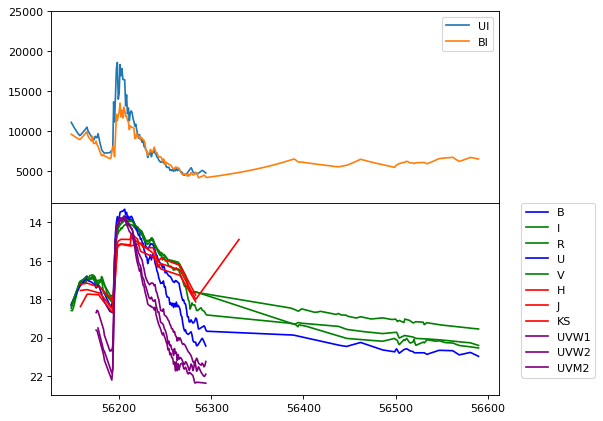

In [104]:
# plot temperature evolution with photometry
fig = plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.4],
                   xticklabels=[], ylim=(1000,25000))
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.4],
                   ylim=(23, 13))

# ax1.plot(MJD, param[:,0], label='All')
# ax1.plot(MJD_band_1, param_band_1[:,0], label='BVRI')
# ax1.plot(MJD_band_2, param_band_2[:,0], label='UBVRI')
# ax1.plot(MJD_band_3, param_band_3[:,0], label='UV--I')
# ax1.plot(MJD_band_4, param_band_4[:,0], label='BVI')
ax1.plot(MJD_band_5, param_band_5[:,0], label='UI')
# ax1.plot(MJD_band_6, param_band_6[:,0], label='UVW2/U')
ax1.plot(MJD_band_7, param_band_7[:,0], label='BI')
ax1.legend()

col = {'UVW2':'purple', 'UVM2':'purple', 'UVW1':'purple', 'U':'blue', 'B':'blue', 'V':'green', 'R':'green', 'I':'green', 
       'J':'red', 'H':'red', 'KS':'red'}
for i in mag_intpol.keys():
    ax2.plot(MJD, mag_intpol[i](MJD), color=col[i], label=i)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

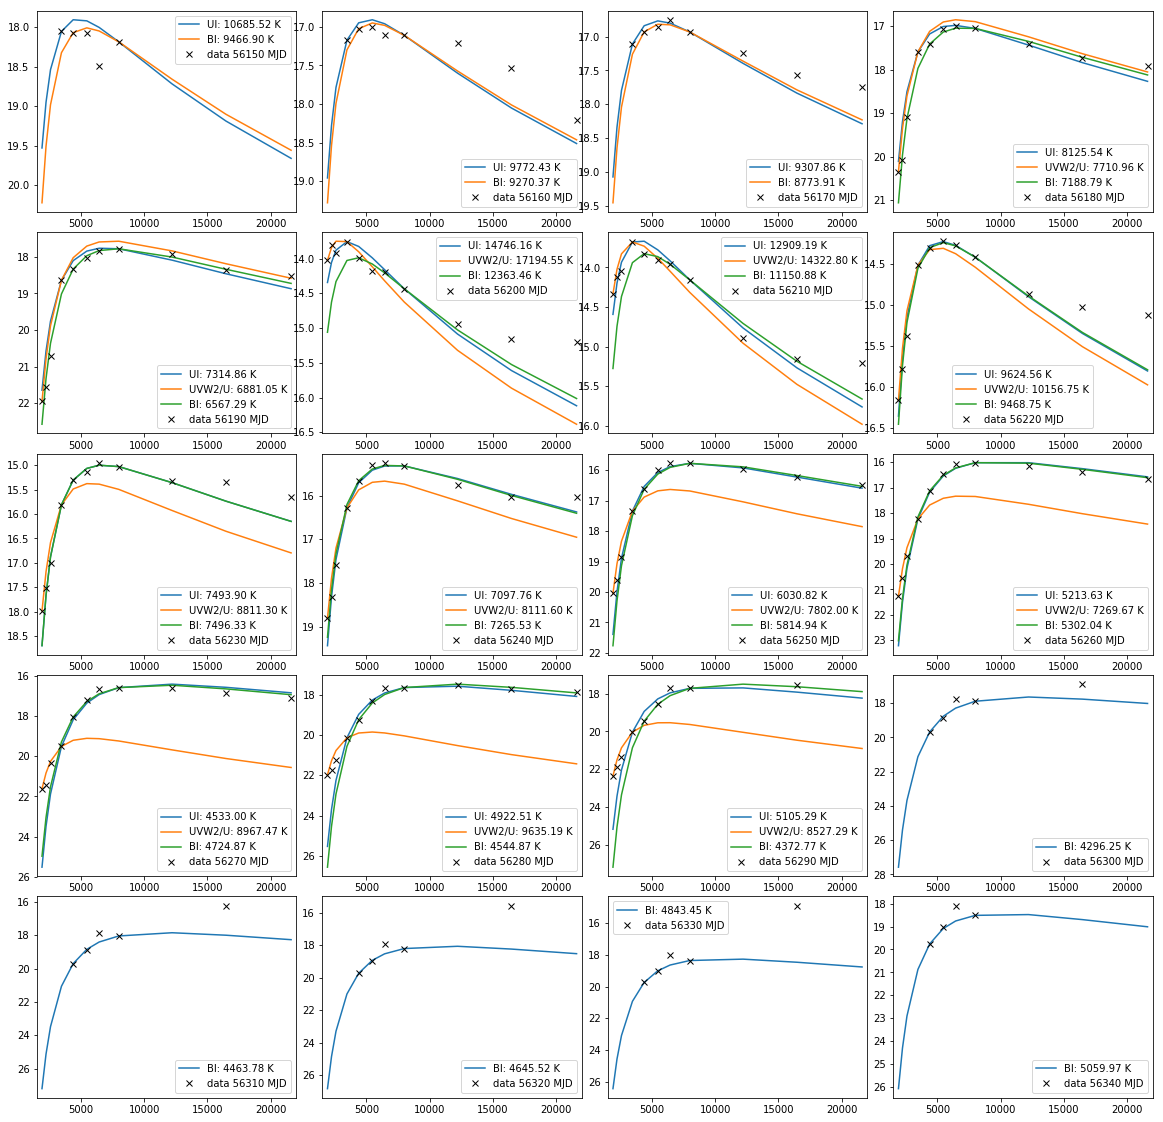

In [105]:
# plot SEDs
z = np.arange(56150, 56350, step=10)
ncol = 4
nrow = int(z.size / ncol)
fig, AX = plt.subplots(nrow, ncol, sharex=False, sharey=False, figsize=(20,5*ncol))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

w = np.fromiter(wavelength.values(), dtype=float)
o = w.argsort()
w = w[o]
j = 0
for ax in AX.flatten():
    
#     index = np.array(np.where(MJD == z[j]))
#     if index.size == 0:
#         j += 1 
#         continue
#     y = get_bb_mag(w, param[index,0][0][0], param[index,1][0][0])
#     ax.plot(w, y, 'k-', label='All : ' + '{:.2f}'.format(param[index,0][0,0]) + ' K') 
    
#     if (z[j] in MJD_band_1):
#         index = np.array(np.where(MJD_band_1 == z[j]))
#         y_band_1 = get_bb_mag(w, param_band_1[index,0][0][0], param_band_1[index,1][0][0])
#         ax.plot(w, y_band_1, label='BVRI: ' + '{:.2f}'.format(param_band_1[index,0][0,0]) + ' K')
        
#     if (z[j] in MJD_band_2):
#         index = np.array(np.where(MJD_band_2 == z[j]))
#         y_band_2 = get_bb_mag(w, param_band_2[index,0][0][0], param_band_2[index,1][0][0])
#         ax.plot(w, y_band_2, label='UBVRI: ' + '{:.2f}'.format(param_band_2[index,0][0,0]) + ' K')
        
#     if (z[j] in MJD_band_3):
#         index = np.array(np.where(MJD_band_3 == z[j]))
#         y_band_3 = get_bb_mag(w, param_band_3[index,0][0][0], param_band_3[index,1][0][0])
#         ax.plot(w, y_band_3, label='UV--I: ' + '{:.2f}'.format(param_band_3[index,0][0,0]) + ' K')
        
#     if (z[j] in MJD_band_4):
#         index = np.array(np.where(MJD_band_4 == z[j]))
#         y_band_4 = get_bb_mag(w, param_band_4[index,0][0][0], param_band_4[index,1][0][0])
#         ax.plot(w, y_band_4, label='BVI: ' + '{:.2f}'.format(param_band_4[index,0][0,0]) + ' K')
        
    if (z[j] in MJD_band_5):
        index = np.array(np.where(MJD_band_5 == z[j]))
        y_band_5 = get_bb_mag(w, param_band_5[index,0][0][0], param_band_5[index,1][0][0])
        ax.plot(w, y_band_5, label='UI: ' + '{:.2f}'.format(param_band_5[index,0][0,0]) + ' K')
        
    if (z[j] in MJD_band_6):
        index = np.array(np.where(MJD_band_6 == z[j]))
        y_band_6 = get_bb_mag(w, param_band_6[index,0][0][0], param_band_6[index,1][0][0])
        ax.plot(w, y_band_6, label='UVW2/U: ' + '{:.2f}'.format(param_band_6[index,0][0,0]) + ' K')

    if (z[j] in MJD_band_7):
        index = np.array(np.where(MJD_band_7 == z[j]))
        y_band_7 = get_bb_mag(w, param_band_7[index,0][0][0], param_band_7[index,1][0][0])
        ax.plot(w, y_band_7, label='BI: ' + '{:.2f}'.format(param_band_7[index,0][0,0]) + ' K')
        
    x, y, a = get_mag_interpol(mag_intpol, z[j])
    o = x.argsort()
    ax.plot(x[o], y[o], 'kx', label='data ' + '{}'.format(z[j]) + ' MJD')
    
#     ax.set_ylim(13,23)
    ax.set_xlim(1500, 22000)
    ax.invert_yaxis()
    ax.legend()
    
    j += 1
    
plt.show()

# Conclusion

- All-band fit looks good.
- UV/U excess is observed during peak given non-UV/U fit, very brieft around 20 days. There might be another UV excess at the earlier outburst. There is another UV excess in nebular phase.
- R has H$alpha$ contamination, which is significant at later times (in nebular phase?), implied by comparing $BVRI$ and $BVI$ fits.
- After peak, $BVI$ fits well from UV to NIR until later times (corresponding to when H$\alpha$ is significant?).
- UV, H$\alpha$, NIR excess is observed again at later times.
- Optical component can be represented by two bands in $BVI$. $BI$ is the best. $VI$ is ok. $BV$ might not be good. $R$ is ok for the component outside of the H$\alpha$-significant period. $U$ can be in the component outside of UV/U excess.

# Next

- Try dereddening. File 02_02 : no significant change as expected.
- Try subtracting optical fit from UV. Then, fit UV with something: power law, polynomial, modified BB.
- Try other objects.